# Forecasting the energy performance of buildings : Python version

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score

## I. Exploration des données 

Dans le cadre du projet Machine Learning nous avons à traiter le problème suivant : prédire le niveau des performances énergétiques de bâtiments. Nous avons 768 bâtiments à évaluer et 8 variables explicatives.   
Les variables qualitatives sont les suivantes :  
- L'orientation 
- Galzing Area Distribution  
Les variables quanatitatives sont les suivantes :
- Relative Compactness 
- Surface Area 
- Wall Area   
- Roof Area 
- Overall Area 
- Glazing Area 

### I.1 Ouverture des données 

In [ ]:
data = pd.read_csv('./DataEnergy-Students.csv')
data.rename(columns={"Load": "Energy"}, inplace = True)
data = data.reset_index(drop = True)
data['orientation'] = data['orientation'].astype('category')
data.head()


,Relative.compactness,Surface.area,Wall.area,Roof.area,Overall.height,orientation,Glazing.area,Glazing.area.distr,Energy,Energy.efficiency
0,0.982928,530.489958,306.484593,112.002683,7.0,North,0.016095,0,34.263943,C
1,0.983547,519.872380,299.776324,110.048028,7.0,East,-0.009387,0,34.589751,C
2,0.979453,516.191221,303.374358,106.408431,7.0,South,-0.000697,0,38.778048,C
3,0.977733,518.924089,292.812213,113.055938,7.0,West,0.000010,0,37.947808,C
4,0.903029,552.968920,316.236102,118.366409,7.0,North,-0.006592,0,47.675859,D


On observe certaines des valeurs de Glazing.area sont négative. Or l'aire n'est jamais négative. On décidera donc de mettre ces valeures négatives abbérantes à zéro. 

In [ ]:
data['Glazing.area'][data['Glazing.area']<0] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### I.2. Etude unidimentionelle la variable réponse

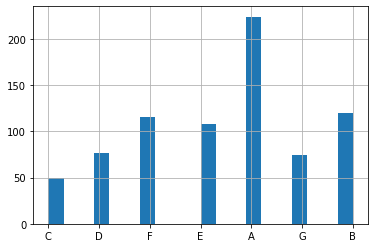

In [ ]:
data["Energy.efficiency"].hist(bins=20)
plt.show()

On observe bien ci-dessous 7 classes de performance d'énergie. Cependant, les classes ne sont pas équilibrées.

### I.3. Etude multidimensionelle

##### Etude des variables Glazing Area et Glazing Area Distribution

On se demande si on utilise ses variables Glazing area et Glazing Area Distribution, car cela peut être redondant. En effet,  la variable Glazing Area Distribution décrit les niveaux (0,1,2,3, 4, et 5) correspondant à glazing aera. 
On décidera finalement de garder la variable Glazing Area car elle contient plus d'information que Glazing Area Distribution, et ce afin de ne pas avoir de redondance d'information. 

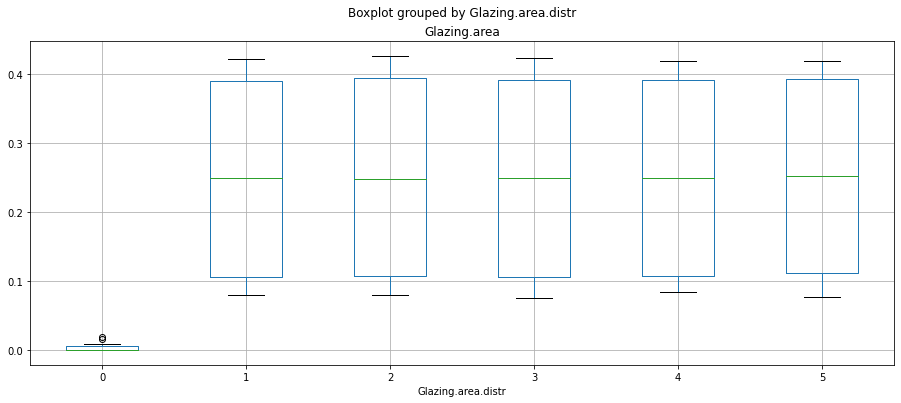

In [ ]:
data.boxplot(column = 'Glazing.area', by = 'Glazing.area.distr', figsize=(15,6))
plt.show()

##### Etude des corrélations 

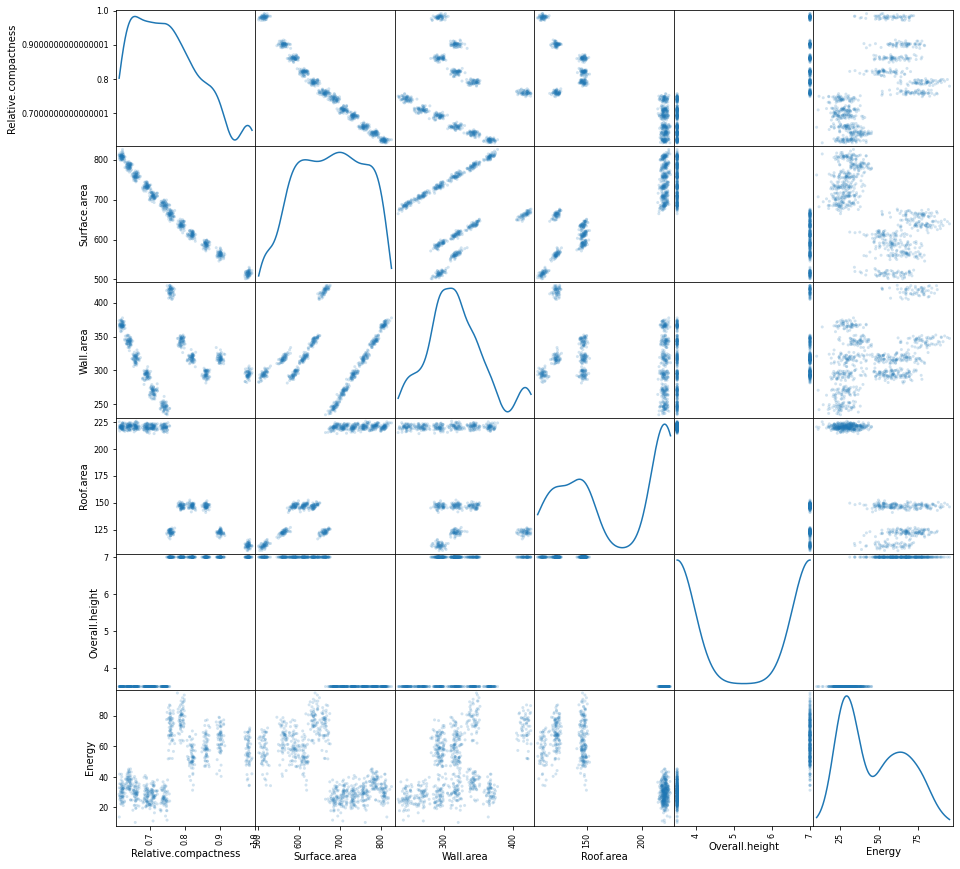

In [ ]:
# scatter plot matrix des variables quantitatives
from pandas.plotting import scatter_matrix
data_quantitatives = data[["Relative.compactness","Surface.area","Wall.area","Roof.area","Overall.height","Energy"]]
scatter_matrix(data_quantitatives, alpha=0.2, figsize=(15, 15), diagonal='kde')
plt.show()

On peut remarquer sur le graphe ci-dessous que les variables Relative Compactness et Surface.area sont linéairement corrélées. Malgré tout, nous gardons les deux variables dans les modèles qui seront implémentés. 

On peut prédire l'énergie à partir d'une valeur de relative compactness ou surface area (les deux "boîtes" en bas à gauche). 

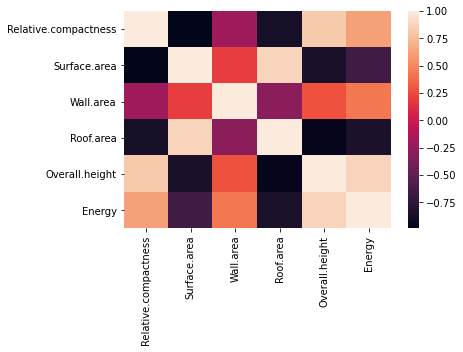

In [ ]:
sns.heatmap(data_quantitatives.corr())

On peut voir ci-dessus que la variable Overall.height et la variable Roof.area sont foterment corrélées.   
Etant donné qu'il manque beaucoup de données entre 150 et 200 pour la variable Roof.area, on décide donc de ne pas prendre en compte cette variable. 

(array([ 66., 126.,   2., 190.,   0.,   0.,   0.,   0.,   0., 384.]),
 array([105.33887561, 117.3807602 , 129.42264479, 141.46452937,
        153.50641396, 165.54829855, 177.59018314, 189.63206772,
        201.67395231, 213.7158369 , 225.75772148]),
 <a list of 10 Patch objects>)

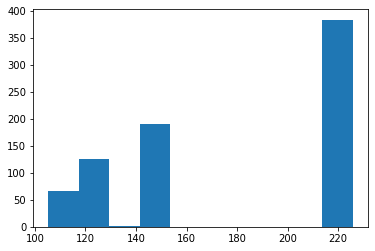

In [ ]:
plt.hist(data['Roof.area'])

In [ ]:
#### Suppression des colonnes Glazing.area.distr & Roof.area
del data['Roof.area']
del data['Glazing.area.distr']
n_features = 6

### I.4. Analyse des Composantes Principales 

In [ ]:
### Libraries 
from sklearn.decomposition import PCA
import sklearn.preprocessing as sp

On fera un pré-processing sur les données car elles ne sont pas toutes à la même échelle. 

In [ ]:
pca = PCA(n_components=2)
data_quantitatives = data[["Relative.compactness","Surface.area","Wall.area","Overall.height",'Glazing.area']]
principalComponents = pca.fit_transform(sp.scale(data_quantitatives))
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, data['Energy.efficiency']], axis = 1)

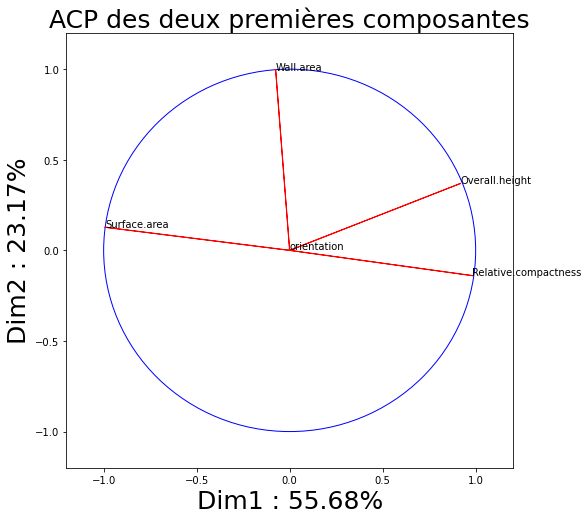

In [ ]:
# coordonnées des variables
coord1=pca.components_[0]*np.sqrt(pca.explained_variance_[0])
coord2=pca.components_[1]*np.sqrt(pca.explained_variance_[1])
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
for i, j, nom in zip(coord1,coord2, data.columns):
    plt.text(i, j, nom)
    plt.arrow(0,0,i,j,color='r')
plt.axis((-1.2,1.2,-1.2,1.2))
# cercle
c=plt.Circle((0,0), radius=1, color='b', fill=False)
ax.add_patch(c)
ax.set_xlabel("Dim1 : " + str(round(pca.explained_variance_ratio_[:10][0]*100,2))+ "%" ,size=25)
ax.set_ylabel("Dim2 : " + str(round(pca.explained_variance_ratio_[:10][1]*100,2)) + "%",size=25)
ax.set_title("ACP des deux premières composantes",size=25)
plt.show()

Commentaire : 
Le graphe représente l'analyse des deux premières composantes principales. Avant de réaliser notre ACP, nous avons réduits nos données à la même échelle afin de pouvoir les placer sur le cercle des corrélations. Plus la variable se rapproche du cercle plus elle est bien représentée dans le plan factoriel et permet donc d'expliquer les composantes principales. 

Une définition et expression des deux axes n'est pas assez tranché et évidente à lire. 

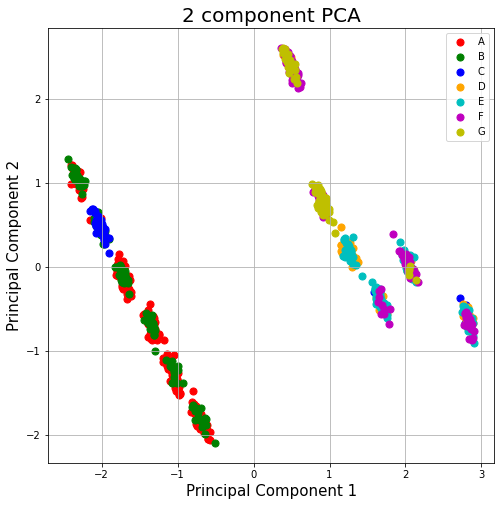

In [ ]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = np.unique(data['Energy.efficiency'])
colors = ['r', 'g', 'b', 'orange','c','m','y']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Energy.efficiency'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()


Commentaire : 
On voit que l'ACP permet déjà de séparer en deux classes les énergies. On peut facilement séparer les A, B de D, F, G et H. La classe C se retrouve dans les deux groupements (mais pen majorité plus proche de A & B). 
On peut donc séparer grâce à l'ACP un bon comportement énergétique d'un mauvais, mais il est plus difficile d'aller dans le détails et en subtilité afin de bien classifier sur les 7 classes grâce à l'ACP.

### I.5 Classification Ascendante Hiérarchique

In [ ]:
#Lecture des données sous la forme de matrices de distances 
data_x = data[["Relative.compactness","Surface.area","Wall.area","Overall.height",'Glazing.area']]

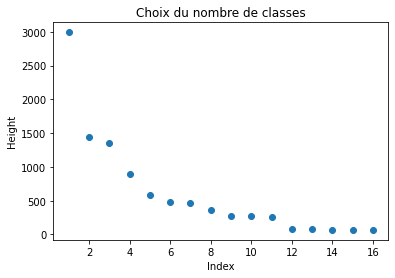

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(data_x, 'ward', metric = 'euclidean') # choix de la distance
height = Z[:, 2]  # Décroissance des sauts
x = np.arange(16) + 1
height = sorted(height, reverse = True)
plt.scatter(x, height[0:16])  #height[0:16]/sum(height[0:16])*100
plt.xlabel('Index')
plt.ylabel('Height')
plt.title("Choix du nombre de classes")
plt.show()

Quel nombre de classe à retenir ?
Pour nous aider, nous avons représenter les sauts d'internies du dendograme selon le nombre de classe retenus. 
Comme on peut le voir ci dessus, nous avons 2 sauts majeurs (celui de 1 à 2 groupes et celui de 3 à 4 groupes) 
Nous pouvons donc retenir 4 groupes.  

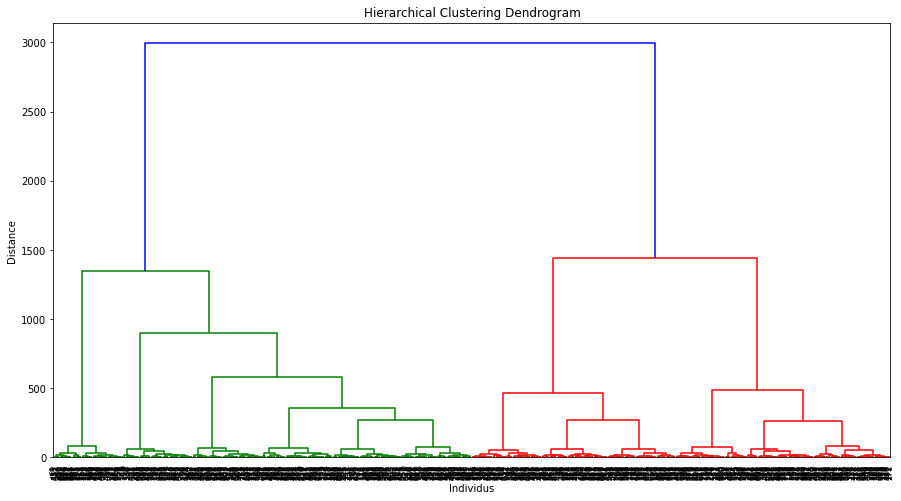

In [ ]:
plt.figure(figsize = (15, 8))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Individus')
plt.ylabel('Distance')
dendrogram(Z,leaf_font_size = 8.)
plt.show()

Nous coupons donc l'arbre à une distance comprise entre 1000 et 1400. 

In [ ]:
## Tableau de résultats pour les parties II et III
Results = pd.DataFrame(columns = ["C_LR_sans_pénalité", "C_LR_Lasso", "C_LR_Ridge", "C_LR_EN", "C_Boosting", "C_OT", "C_RF", "C_SVM", "R_LR_sans_pénalité", "R_LR_Lasso", "R_LR_Ridge", "R_LR_EN", "R_Boosting", "R_OT", "R_RF", "R_SVR"])

## II. Model : Classification 

In [ ]:
### Processing sur le colonne orientation 
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data['orientation']=le.fit_transform(data['orientation'])

In [ ]:
### Train, Test split
from sklearn.model_selection import train_test_split
X = data.iloc[:,0:n_features]
y = data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=109)

Commentaire : 
Lorsqu'on parle de performance d'algorithmes de classification et de regression, il est import de séparer le jeu de donné en données d'entrainement et de tests afin de généraliser nos modéles de prédiction. 

### II.1. Regression Logistique 

#### II.1.1 Regression Logistique sans pénalisation

In [ ]:
### Library 
from sklearn.linear_model import LogisticRegression

In [ ]:
### Model parameters evalutaion 
# evaluation
param=[{"C":[0.5,1,5,10,12,15,30]}]
logitS = GridSearchCV(LogisticRegression(penalty="none", multi_class='multinomial'), param,cv=5,n_jobs=-1)
logitSP=logitS.fit(X_train, y_train)
# paramètre optimal
logitSP.best_params_["C"]
print("Meilleur score (apprentissage) = %f, Meilleur paramètre = %s" %
      (1.-logitSP.best_score_,logitSP.best_params_))

Meilleur score (apprentissage) = 0.508342, Meilleur paramètre = {'C': 0.5}


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
### Model 
# Prediction 
y_chap = logitSP.predict(X_test)

In [ ]:
### Matrice de confusion & Accuracy 
# matrice de confusion
CT = pd.DataFrame(list(zip(y_chap,y_test)), columns=["Prediction","Real"])
display(pd.crosstab(CT.Prediction, CT.Real))
# Accuracy 
acc = metrics.accuracy_score(y_test, y_chap)
print("Accuracy:",acc)
## Cross validation
Results['C_LR_sans_pénalité'] = cross_val_score(logitSP, X, y, cv=5, scoring='accuracy')

Real,A,B,C,D,E,F,G
Prediction,,,,,,,
A,62,39,17,0,0,0,0
E,0,0,1,7,22,8,19
F,0,0,2,8,12,31,3


Accuracy: 0.49783549783549785


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/usr/local/lib/python3.6/dist-packages/sk

#### II.1.2 Regression Logistique avec pénalisation

##### Pénalisation LASSO

In [ ]:
### Model parameters evalutaion 
# evaluation
param=[{"C":[0.5,1,5,10,12,15,30]}]
logitL = GridSearchCV(LogisticRegression(penalty="l1", multi_class='multinomial', solver='saga'), param,cv=5,n_jobs=-1)
# Choix du solver='saga' car compatilité avec la pénalisation l1 et 'multinomial'
logitLasso=logitL.fit(X_train, y_train)
# Sélection du paramètre optimal
logitLasso.best_params_["C"]
print("Meilleur score (apprentissage) = %f, Meilleur paramètre = %s" %
      (1.-logitLasso.best_score_,logitLasso.best_params_))

Meilleur score (apprentissage) = 0.502752, Meilleur paramètre = {'C': 0.5}


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [ ]:
### Model 
# Prediction 
y_chap = logitLasso.predict(X_test)

In [ ]:
### Matrice de confusion & Accuracy 
# matrice de confusion
CT = pd.DataFrame(list(zip(y_chap,y_test)), columns=["Prediction","Real"])
display(pd.crosstab(CT.Prediction, CT.Real))
# Accuracy 
acc = metrics.accuracy_score(y_test, y_chap)
print("Accuracy:",acc)
## Cross validation
Results['C_LR_Lasso'] = cross_val_score(logitLasso, X, y, cv=5, scoring='accuracy')

Real,A,B,C,D,E,F,G
Prediction,,,,,,,
A,62,39,17,0,0,0,0
E,0,0,1,7,22,8,19
F,0,0,2,8,12,31,3


Accuracy: 0.49783549783549785


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

##### Pénalisation RIDGE

In [ ]:
### Model parameters evalutaion 
# evaluation
param=[{"C":[0.5,1,5,10,12,15,30]}]
logitR = GridSearchCV(LogisticRegression(penalty="l2", multi_class='multinomial'), param,cv=5,n_jobs=-1)
logitRidge=logitR.fit(X_train, y_train)
# Sélection du paramètre optimal
logitRidge.best_params_["C"]
print("Meilleur score (apprentissage) = %f, Meilleur paramètre = %s" %
      (1.-logitRidge.best_score_,logitRidge.best_params_))

Meilleur score (apprentissage) = 0.500883, Meilleur paramètre = {'C': 30}


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
### Model 
# Prediction 
yChap = logitRidge.predict(X_test)

In [ ]:
### Matrice de confusion & Accuracy 
# matrice de confusion
CT = pd.DataFrame(list(zip(y_chap,y_test)), columns=["Prediction","Real"])
display(pd.crosstab(CT.Prediction, CT.Real))
# Accuracy 
acc = metrics.accuracy_score(y_test, y_chap)
print("Accuracy:",acc)
## Cross validation
Results['C_LR_Ridge'] = cross_val_score(logitRidge, X, y, cv=5, scoring='accuracy')

Real,A,B,C,D,E,F,G
Prediction,,,,,,,
A,62,39,17,0,0,0,0
E,0,0,1,7,22,8,19
F,0,0,2,8,12,31,3


Accuracy: 0.49783549783549785


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


###### Pénalisation ElasticNet

In [ ]:
### Model parameters evalutaion 
# evaluation
param=[{"C":[0.5,1,5,10,12,15,30]}]
logitE = GridSearchCV(LogisticRegression(penalty="elasticnet", multi_class='multinomial', solver='saga', l1_ratio=0.5), param,cv=5,n_jobs=-1)
logitEN=logitE.fit(X_train, y_train)
# Sélection du paramètre optimal
logitRidge.best_params_["C"]
print("Meilleur score (apprentissage) = %f, Meilleur paramètre = %s" %
      (1.-logitEN.best_score_,logitEN.best_params_))

Meilleur score (apprentissage) = 0.502752, Meilleur paramètre = {'C': 0.5}


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [ ]:
### Model 
# Prediction 
yChap = logitEN.predict(X_test)

In [ ]:
### Matrice de confusion & Accuracy 
# matrice de confusion
CT = pd.DataFrame(list(zip(y_chap,y_test)), columns=["Prediction","Real"])
display(pd.crosstab(CT.Prediction, CT.Real))
# Accuracy 
acc = metrics.accuracy_score(y_test, y_chap)
print("Accuracy:",acc)
## Cross validation
Results['C_LR_EN'] = cross_val_score(logitEN, X, y, cv=5, scoring='accuracy')

Real,A,B,C,D,E,F,G
Prediction,,,,,,,
A,62,39,17,0,0,0,0
E,0,0,1,7,22,8,19
F,0,0,2,8,12,31,3


Accuracy: 0.49783549783549785


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

### II.2. Arbres binaires de décision 

#### II.2.1. Optimal tree 

In [ ]:
### Library 
from sklearn.tree import DecisionTreeClassifier

In [ ]:
### Model parameters evalutaion 
# evaluation
tps0=time.perf_counter()
# Optimisation de la profondeur de l'arbre
param=[{"max_depth":list(range(2,500))}]
tree= GridSearchCV(DecisionTreeClassifier(),param,cv=10,n_jobs=-1)
treeOpt=tree.fit(X_train, y_train)
# paramètre optimal
tps1=(time.perf_counter()-tps0)
print("Temps arbre = %f, Meilleur taux = %f, Meilleur paramètre = %s" % (tps1, 1. - treeOpt.best_score_,treeOpt.best_params_))

Temps arbre = 19.508623, Meilleur taux = 0.132180, Meilleur paramètre = {'max_depth': 360}


In [ ]:
### Model 
# Prediction 
y_chap = treeOpt.predict(X_test)

In [ ]:
### Matrice de confusion & Accuracy 
# matrice de confusion
CT = pd.DataFrame(list(zip(y_chap,y_test)), columns=["Prediction","Real"])
display(pd.crosstab(CT.Prediction, CT.Real))
# Accuracy 
acc = metrics.accuracy_score(y_test, y_chap)
print("Accuracy:",acc)
## Cross validation
Results['C_OT'] = cross_val_score(treeOpt, X, y, cv=5, scoring='accuracy')

Real,A,B,C,D,E,F,G
Prediction,,,,,,,
A,58,4,1,0,0,0,0
B,4,35,0,0,0,0,0
C,0,0,19,0,0,0,0
D,0,0,0,13,3,0,0
E,0,0,0,2,23,1,0
F,0,0,0,0,8,35,4
G,0,0,0,0,0,3,18


Accuracy: 0.8701298701298701


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


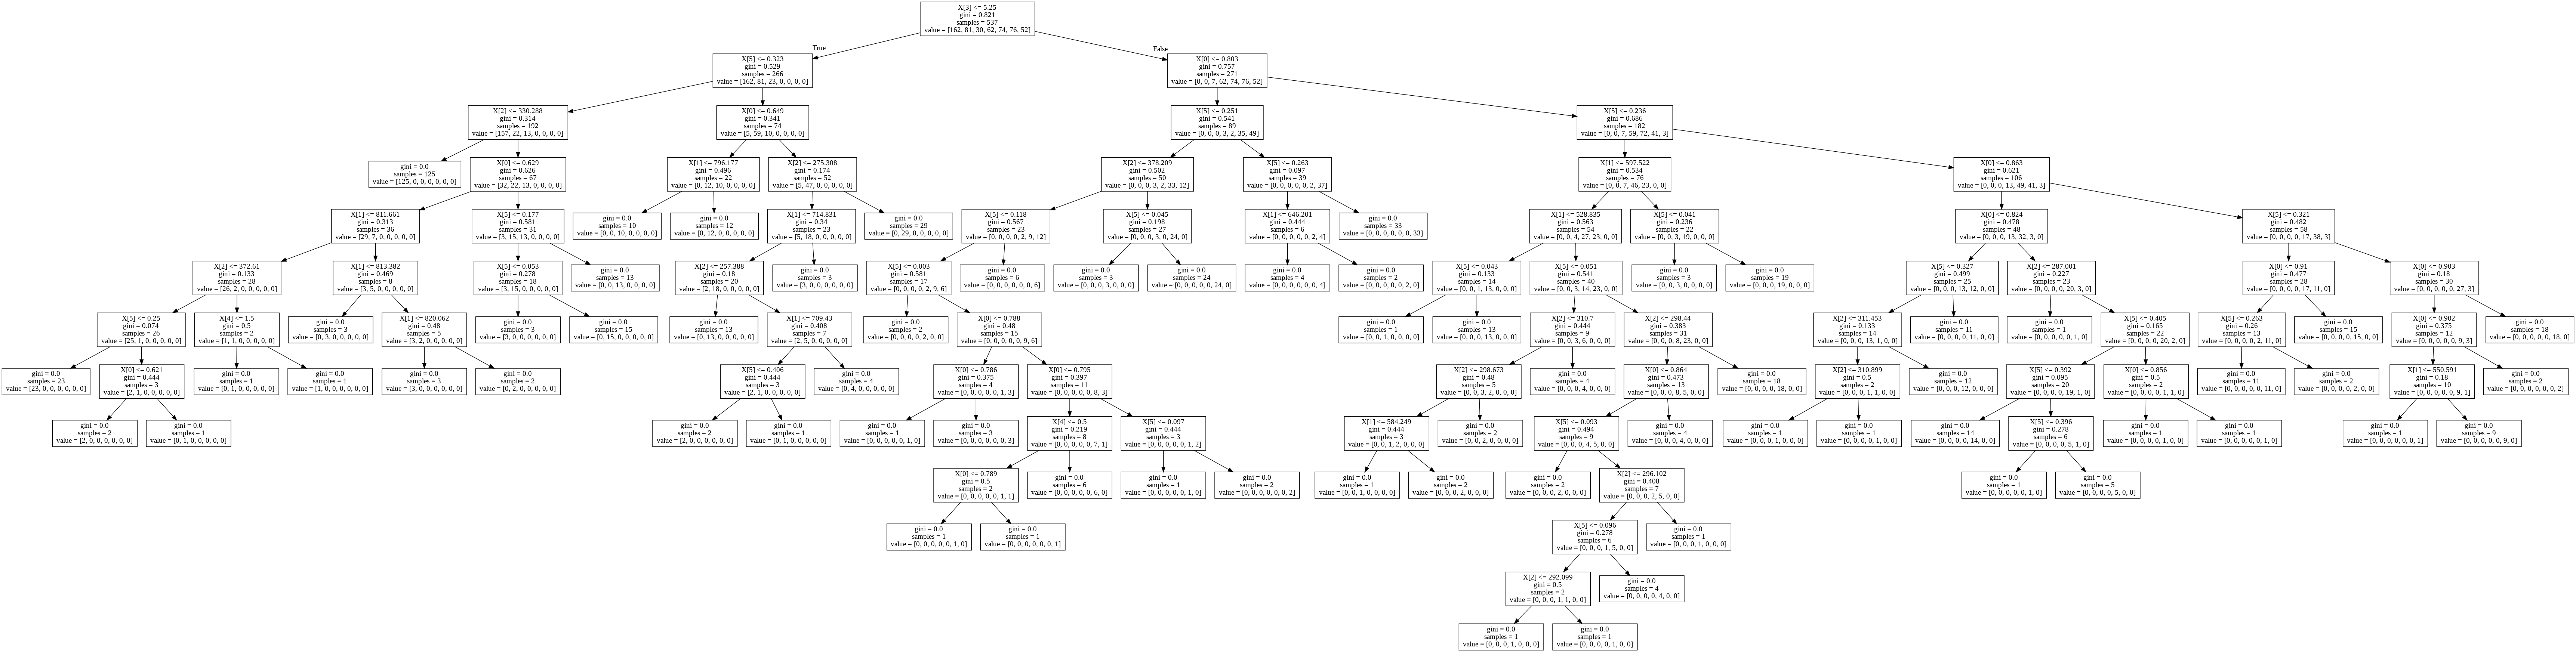

In [ ]:
### Affichage de l'arbre de décision 
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
import pydotplus
from IPython.display import Image
treeG=DecisionTreeClassifier(max_depth=33)
treeG.fit(X_train,y_train)
dot_data = StringIO() 
export_graphviz(treeG, out_file=dot_data) 
graph=pydotplus.graph_from_dot_data(dot_data.getvalue()) 
graph.write_png("treeOpt.png")  
Image(filename='treeOpt.png')

#### II.2.2. Random Forest

In [ ]:
# Library
from sklearn.ensemble import RandomForestClassifier 

In [ ]:
### Model parameters evalutaion 
# evaluation
tps0=time.perf_counter()
param=[{"max_features": list(range(5, 13))}]
rf= GridSearchCV(RandomForestClassifier(n_estimators=100),param,cv=10,n_jobs=-1)
rfOpt=rf.fit(X_train, y_train)
# paramètre optimal
tps1=(time.perf_counter()-tps0)
print("Temps r forest = %f, Meilleur taux = %f, Meilleur paramètre = %s" % (tps1,1. - rfOpt.best_score_, rfOpt.best_params_))

Temps r forest = 6.273301, Meilleur taux = 0.126590, Meilleur paramètre = {'max_features': 6}


In [ ]:
### Model 
# Prediction 
y_chap = rfOpt.predict(X_test)

In [ ]:
### Matrice de confusion & Accuracy 
# matrice de confusion
CT = pd.DataFrame(list(zip(y_chap,y_test)), columns=["Prediction","Real"])
display(pd.crosstab(CT.Prediction, CT.Real))
# Accuracy 
acc = metrics.accuracy_score(y_test, y_chap)
print("Accuracy:",acc)
## Cross validation
Results['C_RF'] = cross_val_score(rfOpt, X, y, cv=5, scoring='accuracy')

Real,A,B,C,D,E,F,G
Prediction,,,,,,,
A,60,0,1,0,0,0,0
B,2,39,0,0,0,0,0
C,0,0,19,0,0,0,0
D,0,0,0,14,3,0,0
E,0,0,0,1,30,2,0
F,0,0,0,0,1,35,3
G,0,0,0,0,0,2,19


Accuracy: 0.935064935064935


Glazing.area 0.36033307245490037
Surface.area 0.17784250729167947
Relative.compactness 0.16531229594196895
Overall.height 0.15996249854899536
Wall.area 0.12654544618982924
orientation 0.010004179572626528


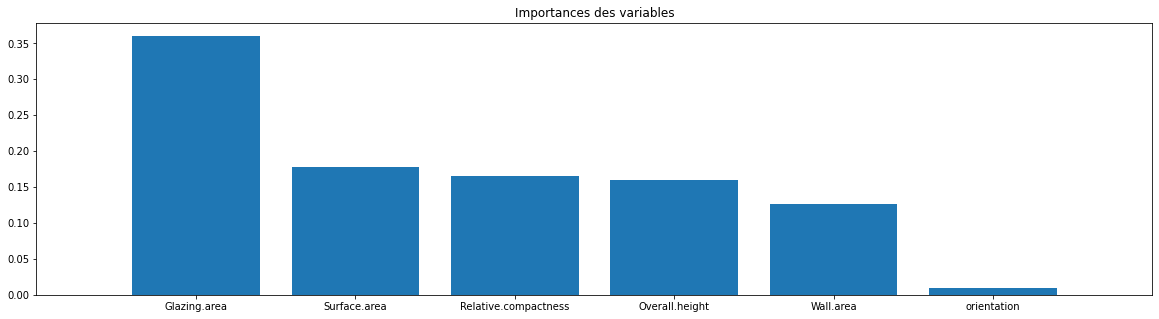

In [ ]:
rf= RandomForestClassifier(n_estimators = 100, max_features = 6  )
rfOpt=rf.fit(X_train, y_train)
# Importance décroissante des variables
importances = rfOpt.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(len(X.columns)):
    print(X_train.columns[indices[f]], importances[indices[f]])
# Graphe des importances
plt.figure(1, figsize=(20, 5))
plt.title("Importances des variables")
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]),X_train.columns[indices])
plt.xlim([-1, X_train.shape[1]])
plt.show()

### II.3 Boosting 

In [ ]:
### Library
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
### Model parameters evalutaion 
# evaluation
paramGrid = [{'n_estimators': list(range(100,601,50)), 'learning_rate': [0.1,0.2,0.3,0.4]}]
gbmC= GridSearchCV(GradientBoostingClassifier(),paramGrid,cv=5,n_jobs=-1)
gbmOpt=gbmC.fit(X_train, y_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - gbmOpt.best_score_,gbmOpt.best_params_))

Meilleur score = 0.152665, Meilleur paramètre = {'learning_rate': 0.4, 'n_estimators': 600}


In [ ]:
### Model training and predict 
# Predict 
y_pred = gbmOpt.predict(X_test)

In [ ]:
### Matrice de confusion & Accuracy 
# matrice de confusion
CT = pd.DataFrame(list(zip(y_pred,y_test)), columns=["Prediction","Real"])
display(pd.crosstab(CT.Prediction, CT.Real))
# Accuracy 
acc = metrics.accuracy_score(y_test, y_chap)
print("Accuracy:",acc)
## Cross validation
Results['C_Boosting'] = cross_val_score(gbmOpt, X, y, cv=5, scoring='accuracy')

Real,A,B,C,D,E,F,G
Prediction,,,,,,,
A,60,3,0,0,0,0,0
B,2,36,2,0,0,0,0
C,0,0,17,0,0,0,0
D,0,0,1,15,6,0,0
E,0,0,0,0,28,7,0
F,0,0,0,0,0,29,3
G,0,0,0,0,0,3,19


Accuracy: 0.935064935064935


### II.4 Super Vector Machine 

In [ ]:
### Library
from sklearn.svm import SVC

In [ ]:
### Model parameters evalutaion 
# evaluation
param=[{"C":[0.4,0.5,0.6,0.8,1,1.4,2,6,10,20,50,100,1000,2000]}]
svm= GridSearchCV(SVC(),param,cv=10,n_jobs=-1)
svmOpt=svm.fit(X_train, y_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - svmOpt.best_score_,svmOpt.best_params_))

Meilleur score = 0.422781, Meilleur paramètre = {'C': 1000}


In [ ]:
### Model training and predict 
# Train
clf = SVC(C=1000, kernel='linear') #kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’
clf.fit(X_train, y_train)
# Predict 
y_pred = clf.predict(X_test)

In [ ]:
### Matrice de confusion & Accuracy 
# matrice de confusion
CT = pd.DataFrame(list(zip(y_pred,y_test)), columns=["Prediction","Real"])
display(pd.crosstab(CT.Prediction, CT.Real))
# Accuracy 
# Accuracy 
acc = metrics.accuracy_score(y_test, y_chap)
print("Accuracy:",acc)
## Cross validation
Results['C_SVM']  = cross_val_score(clf, X, y, cv=5, scoring='accuracy')

Real,A,B,C,D,E,F,G
Prediction,,,,,,,
A,56,7,4,0,0,0,0
B,6,32,13,0,0,0,0
D,0,0,3,10,8,3,3
E,0,0,0,4,25,6,0
F,0,0,0,1,1,30,1
G,0,0,0,0,0,0,18


Accuracy: 0.935064935064935


Nous avons essayé différents kernels pour le paramètre optimisé C=0.6. Voici les accuracy obtenues pour chaque :  
- rbf --> 0.48  
- poly --> 0.44  
- sigmoid --> 0,268  
- Linear --> 0.76  


## III. Model : Regression + Thresholding

In [ ]:
y_reg = data.iloc[:,-2] # dataframe contenant la colonne 'energy efficiency'
X_reg = data.iloc[:,0:n_features] #dataframe contenant les features
X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg,test_size=0.3,random_state=109)

In [ ]:
y_category = data.iloc[:,-1]
y_test_category=y_category.iloc[y_test.index-1] #récupérer la colonne 'energy' level des memes indexes que reg_y_test

### III.1. Regression Logistique 

In [ ]:
### Library
from sklearn import linear_model

#### III.1.1 Regression Logistique sans pénalisation

In [ ]:
### Model 
LinearModel=linear_model.LinearRegression().fit(X_train, y_train)

In [ ]:
# Predict 
y_pred = LinearModel.predict(X_test)

In [ ]:
### Matrice de confusion & Accuracy 
y_pred_category= pd.cut(y_pred, bins=[-1, 30, 35, 45, 55, 65, 75, 100], labels=['A','B','C','D','E','F','G'])
# matrice de confusion
CT = pd.DataFrame(list(zip(y_pred_category,y_test_category)), columns=["Prediction","Real"])
display(pd.crosstab(CT.Prediction, CT.Real))
# Accuracy 
acc = metrics.accuracy_score(y_test_category, y_pred_category)
print("Accuracy:",acc)
# MSE & R2 
print("MSE=",mean_squared_error(y_pred,y_test))
print("R2=",r2_score(y_test,y_pred))
## Cross validation
liste_acc = []
for i in range(5): 
  X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg,test_size=0.3)
  y_test_category=y_category.iloc[y_test.index-1]
  LinearModel=linear_model.LinearRegression().fit(X_train, y_train)
  y_pred = LinearModel.predict(X_test)
  y_pred_category= pd.cut(y_pred, bins=[-1, 30, 35, 45, 55, 65, 75, 100], labels=['A','B','C','D','E','F','G'])
  liste_acc.append(metrics.accuracy_score(y_test_category, y_pred_category))
Results['R_LR_sans_pénalité'] = liste_acc

Real,A,B,C,D,E,F,G
Prediction,,,,,,,
A,49,7,0,0,0,1,0
B,9,18,6,0,0,0,0
C,2,18,8,0,0,0,0
D,2,0,2,5,0,0,0
E,2,1,2,9,19,9,3
F,0,0,0,2,12,23,20
G,0,0,0,0,0,0,2


Accuracy: 0.5367965367965368
MSE= 47.997116470086674
R2= 0.8813121418195723


#### III.1.2 Regression Logistique avec pénalisation

##### Pénalisation LASSO

In [ ]:
### Model parameters evalutaion 
# evaluation
param=[{"alpha":[0.05,0.1,0.2,0.3,0.4,0.5,1]}]
regLasso = GridSearchCV(linear_model.Lasso(), param,cv=5,n_jobs=-1)
regLassOpt=regLasso.fit(X_train, y_train)
# paramètre optimal
regLassOpt.best_params_["alpha"]

0.05

In [ ]:
# Predict 
y_pred = regLassOpt.predict(X_test)

In [ ]:
### Matrice de confusion & Accuracy 
y_pred_category= pd.cut(y_pred, bins=[-1, 30, 35, 45, 55, 65, 75, 100], labels=['A','B','C','D','E','F','G'])
# matrice de confusion
CT = pd.DataFrame(list(zip(y_pred_category,y_test_category)), columns=["Prediction","Real"])
display(pd.crosstab(CT.Prediction, CT.Real))
# Accuracy 
acc = metrics.accuracy_score(y_test_category, y_pred_category)
print("Accuracy:",acc)
# MSE & R2 
print("MSE=",mean_squared_error(y_pred,y_test))
print("R2=",r2_score(y_test,y_pred))
## Cross validation
liste_acc = []
for i in range(5): 
  X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg,test_size=0.3)
  y_test_category=y_category.iloc[y_test.index-1]
  regLassOpt=regLasso.fit(X_train, y_train)
  y_pred = regLassOpt.predict(X_test)
  y_pred_category= pd.cut(y_pred, bins=[-1, 30, 35, 45, 55, 65, 75, 100], labels=['A','B','C','D','E','F','G'])
  liste_acc.append(metrics.accuracy_score(y_test_category, y_pred_category))
Results['R_LR_Lasso']= liste_acc

Real,A,B,C,D,E,F,G
Prediction,,,,,,,
A,48,8,0,0,0,3,1
B,10,11,6,0,0,0,0
C,4,16,8,0,0,0,0
D,0,1,3,0,0,0,0
E,2,1,4,18,21,13,2
F,0,1,0,7,9,18,12
G,0,0,0,0,0,0,4


Accuracy: 0.47619047619047616
MSE= 60.78106730638524
R2= 0.8410216360482254


##### Pénalisation Ridge

In [ ]:
### Model parameters evalutaion 
# evaluation
param=[{"alpha":[0.05,0.1,0.2,0.3,0.4,0.5,1]}]
regRidge = GridSearchCV(linear_model.Ridge(), param,cv=5,n_jobs=-1)
regRidgeOpt=regRidge.fit(X_train,y_train)
# paramètre optimal
regRidgeOpt.best_params_["alpha"]

0.05

In [ ]:
### Model training and predict 
# Predict 
y_pred = regRidgeOpt.predict(X_test)

In [ ]:
### Matrice de confusion & Accuracy 
y_pred_category= pd.cut(y_pred, bins=[-1, 30, 35, 45, 55, 65, 75, 100], labels=['A','B','C','D','E','F','G'])
# matrice de confusion
CT = pd.DataFrame(list(zip(y_pred_category,y_test_category)), columns=["Prediction","Real"])
display(pd.crosstab(CT.Prediction, CT.Real))
# Accuracy 
acc = metrics.accuracy_score(y_test_category, y_pred_category)
print("Accuracy:",acc)
# MSE & R2 
print("MSE=",mean_squared_error(y_pred,y_test))
print("R2=",r2_score(y_test,y_pred))
## Cross validation
liste_acc = []
for i in range(5): 
  X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg,test_size=0.3)
  y_test_category=y_category.iloc[y_test.index-1]
  regRidgeOpt=regRidge.fit(X_train,y_train)
  y_pred = regRidgeOpt.predict(X_test)
  y_pred_category= pd.cut(y_pred, bins=[-1, 30, 35, 45, 55, 65, 75, 100], labels=['A','B','C','D','E','F','G'])
  liste_acc.append(metrics.accuracy_score(y_test_category, y_pred_category))
Results['R_LR_Ridge'] = liste_acc

Real,A,B,C,D,E,F,G
Prediction,,,,,,,
A,45,9,0,0,0,1,0
B,9,17,5,0,0,0,1
C,3,21,10,0,0,0,0
D,3,1,4,6,1,0,0
E,3,1,1,7,21,10,1
F,0,1,0,3,9,17,13
G,0,0,0,0,0,1,7


Accuracy: 0.5324675324675324
MSE= 44.510885237614495
R2= 0.8748427639046888


##### Pénalisation ElasticNet

In [ ]:
### Model parameters evalutaion 
# evaluation
param=[{"alpha":[0.05,0.1,0.2,0.3,0.4,0.5,1]}]
regElasticNet = GridSearchCV(linear_model.ElasticNet(), param,cv=5,n_jobs=-1)
regElasticNetOpt=regElasticNet.fit(X_train, y_train)
# paramètre optimal
regElasticNetOpt.best_params_["alpha"]

0.05

In [ ]:
### Model training and predict 
# Predict 
y_pred = regElasticNetOpt.predict(X_test)

In [ ]:
### Matrice de confusion & Accuracy 
y_pred_category= pd.cut(y_pred, bins=[-1, 30, 35, 45, 55, 65, 75, 100], labels=['A','B','C','D','E','F','G'])
# matrice de confusion
CT = pd.DataFrame(list(zip(y_pred_category,y_test_category)), columns=["Prediction","Real"])
display(pd.crosstab(CT.Prediction, CT.Real))
# Accuracy 
acc = metrics.accuracy_score(y_test_category, y_pred_category)
print("Accuracy:",acc)
# MSE & R2 
print("MSE=",mean_squared_error(y_pred,y_test))
print("R2=",r2_score(y_test,y_pred))
## Cross validation
liste_acc = []
for i in range(5): 
  X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg,test_size=0.3)
  y_test_category=y_category.iloc[y_test.index-1]
  regElasticNetOpt=regElasticNet.fit(X_train, y_train)
  y_pred = regElasticNetOpt.predict(X_test)
  y_pred_category= pd.cut(y_pred, bins=[-1, 30, 35, 45, 55, 65, 75, 100], labels=['A','B','C','D','E','F','G'])
  liste_acc.append(metrics.accuracy_score(y_test_category, y_pred_category))
Results['R_LR_EN'] = liste_acc

Real,A,B,C,D,E,F,G
Prediction,,,,,,,
A,48,7,0,1,0,2,2
B,17,14,10,0,0,0,0
C,5,6,8,0,0,0,0
E,2,2,1,16,28,21,4
F,0,0,0,0,4,13,20


Accuracy: 0.4805194805194805
MSE= 56.353100157223246
R2= 0.8709380482520589


### III.2. Arbres binaires de décision 

#### III.2.1. Optimal tree 

In [ ]:
### Library 
from sklearn.tree import DecisionTreeRegressor

In [ ]:
### Model parameters evalutaion 
# evaluation
param=[{"max_depth":list(range(2,10))}]
tree= GridSearchCV(DecisionTreeRegressor(),param,cv=10,n_jobs=-1)
treeOpt=tree.fit(X_train, y_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - treeOpt.best_score_,treeOpt.best_params_))

Meilleur score = 0.080470, Meilleur paramètre = {'max_depth': 6}


In [ ]:
### Model training and predict 
# Predict
y_pred = treeOpt.predict(X_test)

In [ ]:
### Matrice de confusion & Accuracy 
y_pred_category= pd.cut(y_pred, bins=[-1, 30, 35, 45, 55, 65, 75, 100], labels=['A','B','C','D','E','F','G'])
# matrice de confusion
CT = pd.DataFrame(list(zip(y_pred_category,y_test_category)), columns=["Prediction","Real"])
display(pd.crosstab(CT.Prediction, CT.Real))
# Accuracy 
acc = metrics.accuracy_score(y_test_category, y_pred_category)
print("Accuracy:",acc)
## Cross validation
liste_acc = []
for i in range(5): 
  X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg,test_size=0.3)
  y_test_category=y_category.iloc[y_test.index-1]
  treeOpt=tree.fit(X_train, y_train)
  y_pred = treeOpt.predict(X_test)
  y_pred_category= pd.cut(y_pred, bins=[-1, 30, 35, 45, 55, 65, 75, 100], labels=['A','B','C','D','E','F','G'])
  liste_acc.append(metrics.accuracy_score(y_test_category, y_pred_category))
Results['R_OT'] = liste_acc

Real,A,B,C,D,E,F,G
Prediction,,,,,,,
A,59,7,0,0,0,5,0
B,6,17,4,0,0,0,2
C,9,5,6,0,0,0,0
D,2,0,1,15,5,0,0
E,0,0,0,2,14,5,1
F,0,0,0,1,7,27,4
G,0,0,1,2,2,5,17


Accuracy: 0.670995670995671


#### III.2.2. Random Forest

In [ ]:
### Library 
from sklearn.ensemble import RandomForestRegressor

In [ ]:
### Model parameters evalutaion 
# evaluation
param=[{"max_features":list(range(2,10,1))}]
rf= GridSearchCV(RandomForestRegressor(n_estimators=100),param,cv=5,n_jobs=-1)
rfOpt=rf.fit(X_train, y_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - rfOpt.best_score_,rfOpt.best_params_))

Meilleur score = 0.056942, Meilleur paramètre = {'max_features': 4}


In [ ]:
### Model training and predict 
# Predict
y_pred = rfOpt.predict(X_test)

In [ ]:
### Matrice de confusion & Accuracy 
y_pred_category= pd.cut(y_pred, bins=[-1, 30, 35, 45, 55, 65, 75, 100], labels=['A','B','C','D','E','F','G'])
# matrice de confusion
CT = pd.DataFrame(list(zip(y_pred_category,y_test_category)), columns=["Prediction","Real"])
display(pd.crosstab(CT.Prediction, CT.Real))
# Accuracy 
acc = metrics.accuracy_score(y_test_category, y_pred_category)
print("Accuracy:",acc)
## Cross validation
liste_acc = []
for i in range(5): 
  X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg,test_size=0.3)
  y_test_category=y_category.iloc[y_test.index-1]
  rfOpt=rf.fit(X_train, y_train)
  y_pred = rfOpt.predict(X_test)
  y_pred_category= pd.cut(y_pred, bins=[-1, 30, 35, 45, 55, 65, 75, 100], labels=['A','B','C','D','E','F','G'])
  liste_acc.append(metrics.accuracy_score(y_test_category, y_pred_category))
Results['R_RF']= liste_acc

Real,A,B,C,D,E,F,G
Prediction,,,,,,,
A,52,2,0,1,0,4,1
B,8,28,5,0,0,0,0
C,4,2,10,1,0,0,0
D,3,1,0,14,4,1,0
E,2,1,0,3,23,8,1
F,0,1,1,1,5,21,3
G,0,0,0,1,2,3,14


Accuracy: 0.7012987012987013


### III.3 Boosting 

In [ ]:
### Library 
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
### Model parameters evalutaion 
# evaluation
tps0 = time.perf_counter()
param = [{"n_estimators": [50, 100, 150]}]
gbmReg = GridSearchCV(GradientBoostingRegressor(random_state=0), param)
gbmOptReg = gbmReg.fit(X_train, y_train)
# paramètre optimal
tps1 = (time.perf_counter() - tps0)
print("Temps boosting = %f, Meilleur taux = %f, Meilleur paramètre = %s" % (tps1,1. - gbmOptReg.best_score_, gbmOptReg.best_params_))

Temps boosting = 1.318775, Meilleur taux = 0.062670, Meilleur paramètre = {'n_estimators': 100}


In [ ]:
### Model training and predict 
# Predict
y_pred = gbmOptReg.predict(X_test)

In [ ]:
### Matrice de confusion & Accuracy 
y_pred_category= pd.cut(y_pred, bins=[-1, 30, 35, 45, 55, 65, 75, 100], labels=['A','B','C','D','E','F','G'])
# matrice de confusion
CT = pd.DataFrame(list(zip(y_pred_category,y_test_category)), columns=["Prediction","Real"])
display(pd.crosstab(CT.Prediction, CT.Real))
# Accuracy 
acc = metrics.accuracy_score(y_test_category, y_pred_category)
print("Accuracy:",acc)
liste_acc = []
for i in range(5): 
  X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg,test_size=0.3)
  y_test_category=y_category.iloc[y_test.index-1]
  gbmOptReg = gbmReg.fit(X_train, y_train)
  y_pred = gbmOptReg.predict(X_test)
  y_pred_category= pd.cut(y_pred, bins=[-1, 30, 35, 45, 55, 65, 75, 100], labels=['A','B','C','D','E','F','G'])
  liste_acc.append(metrics.accuracy_score(y_test_category, y_pred_category))

Results['R_Boosting'] = liste_acc

Real,A,B,C,D,E,F,G
Prediction,,,,,,,
A,55,4,1,0,0,3,0
B,13,27,3,0,0,0,0
C,3,3,18,0,0,0,0
D,0,0,0,16,5,0,0
E,1,0,0,5,20,10,0
F,0,1,0,0,1,18,6
G,0,0,0,1,1,0,16


Accuracy: 0.7359307359307359


### III.4 Super Vector Regression

In [ ]:
### Library 
from sklearn.svm import SVR

In [ ]:
### Model parameters evalutaion 
# evaluation
param=[{"C":[0.4,0.5,0.6,0.8,1,1.4,2,6,10,20,50,100,1000,2000]}]
svr= GridSearchCV(SVR(kernel = 'linear'),param,cv=10,n_jobs=-1)
svrOpt=svr.fit(X_train, y_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - svrOpt.best_score_,svmOpt.best_params_))

Meilleur score = 0.137871, Meilleur paramètre = {'C': 1000}


In [ ]:
### Model training and predict 
# Predict
y_pred = svrOpt.predict(X_test)

In [81]:
### Matrice de confusion & Accuracy 
y_pred_category= pd.cut(y_pred, bins=[-1, 30, 35, 45, 55, 65, 75, 100], labels=['A','B','C','D','E','F','G'])
# matrice de confusion
CT = pd.DataFrame(list(zip(y_pred_category,y_test_category)), columns=["Prediction","Real"])
display(pd.crosstab(CT.Prediction, CT.Real))
# Accuracy 
acc = metrics.accuracy_score(y_test_category, y_pred_category)
Results['R_SVR']['Accuracy'] = acc
print("Accuracy:",acc)
# Cross Validation
liste_acc = []
for i in range(5): 
  X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg,test_size=0.3)
  y_test_category=y_category.iloc[y_test.index-1]
  svrOpt=svr.fit(X_train, y_train)
  y_pred = svrOpt.predict(X_test)
  y_pred_category= pd.cut(y_pred, bins=[-1, 30, 35, 45, 55, 65, 75, 100], labels=['A','B','C','D','E','F','G'])
  liste_acc.append(metrics.accuracy_score(y_test_category, y_pred_category))
Results['R_SVR'] = liste_acc

Real,A,B,C,D,E,F,G
Prediction,,,,,,,
A,48,7,0,0,0,5,0
B,12,18,8,0,0,0,2
C,4,11,8,0,0,0,0
D,0,0,2,7,4,0,0
E,2,1,1,17,18,10,4
F,1,0,0,0,5,16,14
G,0,0,0,0,0,0,6


Accuracy: 0.5238095238095238


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## IV. Comparaison et conclusion 

In [82]:
Results.describe()

,C_LR_sans_pénalité,C_LR_Lasso,C_LR_Ridge,C_LR_EN,C_Boosting,C_OT,C_RF,C_SVM,R_LR_sans_pénalité,R_LR_Lasso,R_LR_Ridge,R_LR_EN,R_Boosting,R_OT,R_RF,R_SVR
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.483159,0.493574,0.479263,0.494873,0.794381,0.798243,0.811383,0.666718,0.524675,0.540260,0.545455,0.479654,0.709957,0.694372,0.687446,0.507359
std,0.039104,0.043703,0.040393,0.041320,0.150442,0.126053,0.128811,0.114415,0.013826,0.038159,0.025242,0.026580,0.020986,0.028155,0.050243,0.040886
min,0.422078,0.428571,0.422078,0.435065,0.538961,0.590909,0.603896,0.480519,0.506494,0.480519,0.506494,0.458874,0.675325,0.658009,0.614719,0.445887
25%,0.474026,0.474026,0.467532,0.474026,0.777778,0.764706,0.810458,0.647059,0.515152,0.536797,0.541126,0.458874,0.709957,0.679654,0.666667,0.489177
50%,0.487013,0.509804,0.474026,0.509804,0.870130,0.870130,0.824675,0.701299,0.528139,0.536797,0.549784,0.476190,0.714286,0.692641,0.688312,0.519481
75%,0.509804,0.512987,0.503268,0.512987,0.889610,0.882353,0.863636,0.725490,0.532468,0.571429,0.554113,0.480519,0.718615,0.709957,0.727273,0.532468
max,0.522876,0.542484,0.529412,0.542484,0.895425,0.883117,0.954248,0.779221,0.541126,0.575758,0.575758,0.523810,0.731602,0.731602,0.740260,0.549784


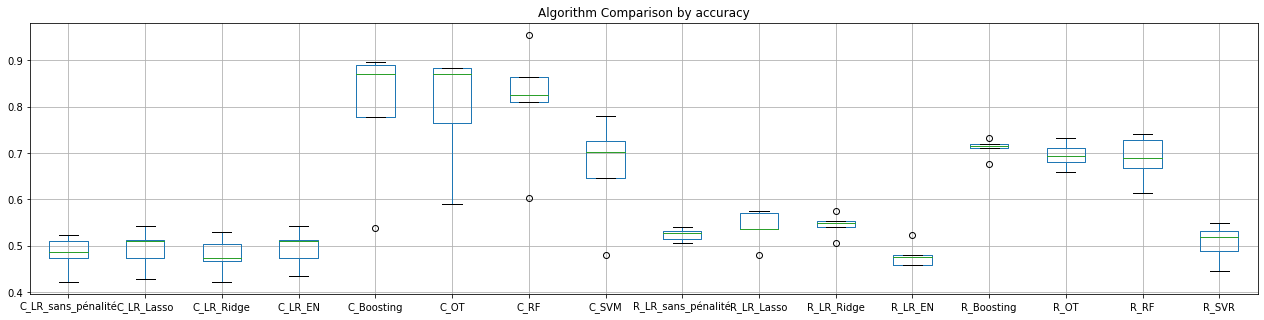

In [83]:
plt.figure(figsize=(22,5))
plt.title('Algorithm Comparison by accuracy')
Results.boxplot()